In [5]:
!pip install xgboost

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib

# A tiny pool of fictional retention agents
AGENTS = ["Aditi Sharma", "Rahul Singh", "Meera Iyer",
          "Santosh Rao", "Kunal Desai", "Anita Paul"]

In [41]:
df = pd.read_csv("C:/Users/G Uday Kiran Reddy/apps/Downloads/synthetic_insurance_churn_dataset.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   10000 non-null  object 
 1   Gender                       10000 non-null  object 
 2   Age                          10000 non-null  int64  
 3   Tenure_Years                 10000 non-null  int64  
 4   Policy_Type                  10000 non-null  object 
 5   Annual_Premium               10000 non-null  int64  
 6   No_of_Claims                 10000 non-null  int64  
 7   Complaint_Registered         10000 non-null  object 
 8   Satisfaction_Score           10000 non-null  int64  
 9   Website_Usage_Per_Week       10000 non-null  int64  
 10  Last_Premium_Change_Percent  10000 non-null  float64
 11  Competitor_Price_Comparison  10000 non-null  int64  
 12  Churn_Score_Percentage       10000 non-null  float64
dtypes: float64(2), in

In [42]:
df['Churned'] = (df['Churn_Score_Percentage'] >= 50).astype(int)

# Feature / target split
X = df.drop(['CustomerID', 'Churn_Score_Percentage', 'Churned'], axis=1)
y = df['Churned']

# Identify categorical+numeric cols
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Pre‑processing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    objective='binary:logistic', eval_metric='auc', random_state=42)

model = Pipeline(steps=[('prep', preprocess),
                       ('xgb', clf)])

model.fit(X_train, y_train)

# Evaluation
pred_proba = model.predict_proba(X_test)[:, 1]
pred = (pred_proba >= 0.5).astype(int)
print("AUC:", roc_auc_score(y_test, pred_proba))
print(classification_report(y_test, pred))


AUC: 0.9325249495069503
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1772
           1       0.70      0.53      0.60       228

    accuracy                           0.92      2000
   macro avg       0.82      0.75      0.78      2000
weighted avg       0.91      0.92      0.92      2000



In [44]:
joblib.dump(model, "models/churn_classifier_xgb.pkl")

['models/churn_classifier_xgb.pkl']

In [59]:
df['Predicted_Churn_Prob'] = model.predict_proba(X)[:, 1]  # 0‑1
df['Predicted_Churn_%']   = (df['Predicted_Churn_Prob'] * 100).round(2)

In [60]:
def classify_status(row):
    """Return one of: 'Already_Left', 'Likely_to_Leave', 'Stable'."""
    if row['Churned'] == 1:
        return 'Already_Left'
    if row['Predicted_Churn_%'] >= 0.70:
        return 'Likely_to_Leave'
    return 'Stable'

df['Status'] = df.apply(classify_status, axis=1)

# Round‑robin agent assignment
df['Retention_Agent'] = [AGENTS[i % len(AGENTS)] for i in range(len(df))]

# Action rules
def action_plan(row):
    if row['Status'] == 'Already_Left':
        return "Win‑back call by agent {0} + 25% discount on re‑joining Premium plan".format(row['Retention_Agent'])
    elif row['Status'] == 'Likely_to_Leave':
        tenure = row['Tenure_Years']
        if tenure >= 5:
            return "Email + phone call from {0}: offer 15% loyalty discount, free roadside assist add‑on".format(row['Retention_Agent'])
        else:
            return "Proactive email: upgrade to Standard with 10% discount".format(row['Retention_Agent'])
    else:
        return "Thank‑you email with wellness gift voucher"

df['Recommended_Action'] = df.apply(action_plan, axis=1)

In [61]:
campaign_cols = ['CustomerID', 'Status', 'Predicted_Churn_%',
                 'Retention_Agent', 'Recommended_Action']
out_path = "output/campaign_plan.csv"
df[campaign_cols].to_csv(out_path, index=False)
print("Campaign file saved to:", out_path)

Campaign file saved to: output/campaign_plan.csv


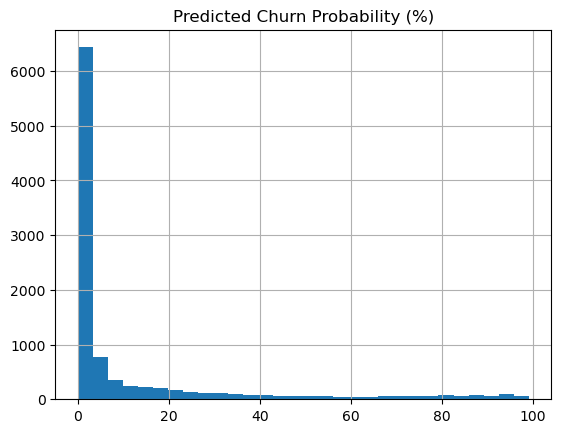

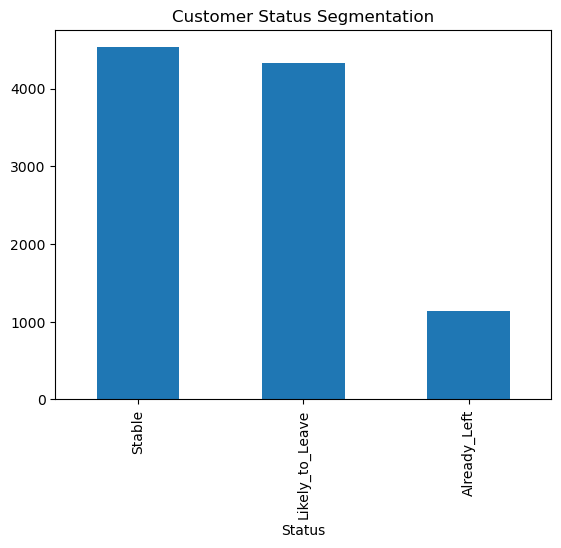

In [62]:
import matplotlib.pyplot as plt

# Distribution of predicted churn %
df['Predicted_Churn_%'].hist(bins=30)
plt.title("Predicted Churn Probability (%)")
plt.show()

# Count per status
df['Status'].value_counts().plot(kind='bar')
plt.title("Customer Status Segmentation")
plt.show()